## https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/swin_unetr_brats21_segmentation_3d.ipynb 참조 코드

In [ ]:
#!pip install monai[all]
#!pip install einops

In [1]:
!python -c "import monai"
!pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib"
!pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch

print_config()

## 여기서부터 본격적으로 모델 학습을 위한 코드가 시작됨

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = "/home/alpaco/msk/monai"
os.makedirs(root_dir, exist_ok=True) 
print(root_dir)

/home/alpaco/msk/monai


In [4]:
class AverageMeter(object):
   def __init__(self):
       self.reset()

   def reset(self):
       self.val = 0
       self.avg = 0
       self.sum = 0
       self.count = 0

   def update(self, val, n=1):
       self.val = val
       self.sum += val * n
       self.count += n
       self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

def datafold_read(datalist, basedir, fold=0, key="training"):
        with open(datalist) as f:
            json_data = json.load(f)

        json_data = json_data[key]


        for d in json_data:
            for k in d:
                if isinstance(d[k], list):
                    d[k] = [os.path.join(basedir, iv) for iv in d[k]]
                elif isinstance(d[k], str):
                    d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

        tr = []
        val = []

        for d in json_data:
            if "fold" in d and d["fold"] == fold:
                val.append(d)
            else:
                tr.append(d)

        return tr, val

def save_checkpoint(model, epoch, filename="swint1ce.pt", best_acc=0, dir_add=root_dir):
   state_dict = model.state_dict()
   save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
   filename = os.path.join(dir_add, filename)
   torch.save(save_dict, filename)
   print("Saving checkpoint", filename)

## Setup dataloader

In [5]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    train_files, validation_files = datafold_read(datalist=json_list, basedir=data_dir, fold=fold)
    
    # json 파일의 경로를 실제 데이터 구조에 맞게 수정
    def fix_path(item):
        if 'image' in item:
            # TrainingData 폴더 참조 제거 및 t1ce 영상(1번인덱스)만 선택
            path = item['image'][1].replace('TrainingData/', '')
            item['image'] = [path]
        if 'label' in item:
            item['label'] = item['label'].replace('TrainingData/', '')
        return item
    
    # 모든 파일 경로 수정
    train_files = [fix_path(item) for item in train_files]
    validation_files = [fix_path(item) for item in validation_files]
    
    print("경로 수정 후 샘플:")
    if train_files:
        print(f"이미지 경로: {train_files[0]['image'][0]}")
        print(f"라벨 경로: {train_files[0]['label']}")
    
    # 존재하는 파일만 필터링
    train_files = [item for item in train_files 
                  if os.path.exists(item['image'][0]) and os.path.exists(item['label'])]
    validation_files = [item for item in validation_files 
                       if os.path.exists(item['image'][0]) and os.path.exists(item['label'])]
    
    print(f"\n유효한 학습 파일 수: {len(train_files)}")
    print(f"유효한 검증 파일 수: {len(validation_files)}")
    
    if len(train_files) == 0 or len(validation_files) == 0:
        raise ValueError("사용 가능한 데이터가 없습니다. 데이터 경로를 확인해주세요.")


    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),  # 채널 차원 확인
            transforms.LabelToMaskd(keys="label",select_labels=[1,2,4]),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),  # 채널 차원 확인
            transforms.LabelToMaskd(keys="label",select_labels=[1,2,4]), # 이진 레이블 변환
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader

In [ ]:
data_dir = "BraTS2021_Data/"  # Update this with your data directory
json_list = "./brats21_folds.json"  # Update this with your json file
roi = (128, 128, 128) #관심영역 (내가 이만큼 크기를 갖다 학습하겠다)
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 60
val_every = 10
start_epoch = 1
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

경로 수정 후 샘플:
이미지 경로: /home/alpaco/msk/BraTS2021_Data/BraTS2021_01146/BraTS2021_01146_t1ce.nii.gz
라벨 경로: /home/alpaco/msk/BraTS2021_Data/BraTS2021_01146/BraTS2021_01146_seg.nii.gz

유효한 학습 파일 수: 1001
유효한 검증 파일 수: 250


monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


## Create Swin UNETR model

In this scetion, we create Swin UNETR model for the 3-class brain tumor semantic segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.  

In [7]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=roi,
    in_channels=1,  # T1 모달리티만 사용
    out_channels=1,  # 이진 분할이므로 1개의 출력 채널만 필요
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


## Optimizer and loss function

In [8]:
def dice_loss(y_pred, y_true):
    eps = 1e-7  # 작은 값을 더해서 0으로 나누는 것을 방지
    intersection = torch.sum(y_pred * y_true) * 2.0
    union = torch.sum(y_pred) + torch.sum(y_true) + eps
    dice_score = intersection / union
    return 1.0 - dice_score

def dice_acc(y_pred, y_true):
    eps = 1e-7
    intersection = torch.sum(y_pred * y_true) * 2.0
    union = torch.sum(y_pred) + torch.sum(y_true) + eps
    return intersection / union

# 학습 관련 설정
loss_func = dice_loss
acc_func = dice_acc

In [9]:
torch.backends.cudnn.benchmark = True
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)  

# sliding window inference 설정
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

# 옵티마이저와 스케줄러 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

## Define Train and Validation Epoch

In [10]:
def train_epoch(model, loader, optimizer, epoch, loss_func, acc_func, post_sigmoid, post_pred):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    run_dice = AverageMeter()

    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        logits = model(data)
        
        # sigmoid 적용
        outputs = post_sigmoid(logits)
        loss = loss_func(outputs, target)
        loss.backward()
        optimizer.step()
        
        # dice score 계산
        val_outputs = post_pred(outputs)
        not_nans = torch.sum(~torch.isnan(target))
        if not_nans > 0:
            train_dice = acc_func(val_outputs, target)
            run_dice.update(float(train_dice.cpu().numpy()), n=float(not_nans.cpu().numpy()))
        
        batch_size = data.shape[0]
        run_loss.update(loss.item(), n=batch_size)
        
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "dice: {:.4f}".format(float(run_dice.avg)),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    
    return run_loss.avg, run_dice.avg

def val_epoch(model, loader, epoch, loss_func, acc_func, model_inferer, post_sigmoid, post_pred):
    model.eval()
    start_time = time.time()
    run_loss = AverageMeter()
    run_dice = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            
            # sigmoid 적용
            outputs = post_sigmoid(logits)
            loss = loss_func(outputs, target)
            
            # dice score 계산
            val_outputs = post_pred(outputs)
            not_nans = torch.sum(~torch.isnan(target))
            if not_nans > 0:
                val_dice = acc_func(val_outputs, target)
                run_dice.update(float(val_dice.cpu().numpy()), n=float(not_nans.cpu().numpy()))
            
            batch_size = data.shape[0]
            run_loss.update(loss.item(), n=batch_size)
            
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                "loss: {:.4f}".format(run_loss.avg),
                "dice: {:.4f}".format(float(run_dice.avg)),
                "time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()
    
    return run_dice.avg, run_loss.avg

## Define Trainer

In [11]:
import csv
import os
import time
import torch
import numpy as np

def trainer(model, train_loader, val_loader, optimizer, loss_func, acc_func, scheduler, 
           model_inferer, start_epoch, post_sigmoid, post_pred, csv_file):
    
    # 절대 경로 직접 지정
    root_dir = "/home/alpaco/msk/monai"
    os.makedirs(root_dir, exist_ok=True)
    
    csv_path = os.path.join(root_dir, "swint1cebinary.csv")
    best_model_path = os.path.join(root_dir, "swint1ce.pt")
    checkpoint_path = os.path.join(root_dir, "swint1ce.pt")
    
    print(f"CSV will be saved to: {csv_path}")
    print(f"Best model will be saved to: {best_model_path}")
    print(f"Checkpoints will be saved to: {checkpoint_path}")
    
    # 체크포인트 불러오기
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        val_acc_max = checkpoint['val_acc_max']
        loss_epochs = checkpoint.get('loss_epochs', [])
        dice_scores = checkpoint.get('dice_scores', [])
        trains_epoch = checkpoint.get('trains_epoch', [])
        print(f"Resuming from epoch {start_epoch}")
    else:
        val_acc_max = 0.0
        dice_scores = []
        loss_epochs = []
        trains_epoch = []
    
    # CSV 파일 헤더 생성
    if not os.path.exists(csv_path):
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_dice', 'val_loss', 'val_dice', 'learning_rate'])
    
    try:
        for epoch in range(start_epoch, max_epochs+1):
            # 학습
            train_loss, train_dice = train_epoch(
                model=model, 
                loader=train_loader, 
                optimizer=optimizer, 
                epoch=epoch, 
                loss_func=loss_func,
                acc_func=acc_func,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred
            )
            
            loss_epochs.append(train_loss)
            trains_epoch.append(train_dice)
            
            # Validation
            if epoch % val_every == 0 or epoch == 0:
                val_acc, val_loss = val_epoch(
                    model=model,
                    loader=val_loader,
                    epoch=epoch,
                    loss_func=loss_func,
                    acc_func=acc_func,
                    model_inferer=model_inferer,
                    post_sigmoid=post_sigmoid,
                    post_pred=post_pred,
                )
                
                dice_scores.append(val_acc)
                
                # 최고 성능 모델 저장
                if val_acc > val_acc_max:
                    val_acc_max = val_acc
                    try:
                        save_dict = {
                            "epoch": epoch,
                            "state_dict": model.state_dict(),
                            "optimizer": optimizer.state_dict(),
                            "val_acc": val_acc,
                        }
                        torch.save(save_dict, best_model_path)
                        print(f"Best model saved at epoch {epoch} with validation accuracy: {val_acc:.4f}")
                        print(f"Saved to: {best_model_path}")
                    except Exception as e:
                        print(f"Error saving model: {str(e)}")
            else:
                val_acc, val_loss = None, None
            
            # 현재 학습률
            current_lr = optimizer.param_groups[0]['lr']
            
            # CSV에 결과 저장
            try:
                with open(csv_path, 'a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow([
                        epoch,
                        float(train_loss),
                        float(train_dice),
                        float(val_loss) if val_loss is not None else '',
                        float(val_acc) if val_acc is not None else '',
                        float(current_lr)
                    ])
            except Exception as e:
                print(f"Error saving CSV: {str(e)}")
            
            # 체크포인트 저장
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc_max': val_acc_max,
                'loss_epochs': loss_epochs,
                'dice_scores': dice_scores,
                'trains_epoch': trains_epoch
            }, checkpoint_path)
            
            scheduler.step()
            
    except KeyboardInterrupt:
        print("\nTraining interrupted. Saving checkpoint...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc_max': val_acc_max,
            'loss_epochs': loss_epochs,
            'dice_scores': dice_scores,
            'trains_epoch': trains_epoch
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    
    return val_acc_max, dice_scores, loss_epochs, trains_epoch

## Execute training

In [ ]:
#!pip install nvidia-smi

In [12]:
import torch
# CUDA 사용 가능 여부 확인
if torch.cuda.is_available():
    print("CUDA is available.")
    # CUDA 디바이스 수 확인
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {num_devices}")
    # 각 디바이스 정보 출력
    for i in range(num_devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  - Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
else:
    print("CUDA is not available.")

CUDA is available.
Number of CUDA devices: 4
Device 0: NVIDIA GeForce RTX 3090
  - Memory Allocated: 0.00 MB
  - Memory Cached: 0.00 MB
Device 1: NVIDIA GeForce RTX 3090
  - Memory Allocated: 0.00 MB
  - Memory Cached: 0.00 MB
Device 2: NVIDIA GeForce RTX 3090
  - Memory Allocated: 0.00 MB
  - Memory Cached: 0.00 MB
Device 3: NVIDIA GeForce RTX 3090
  - Memory Allocated: 245.36 MB
  - Memory Cached: 254.00 MB


In [13]:
import subprocess

# nvidia-smi 명령어 실행
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout)

Fri Nov 29 21:24:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:07:00.0 Off |                  N/A |
| 40%   80C    P2             344W / 350W |  20228MiB / 24576MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# 학습 시작
print(f"Starting training... Results will be saved to /home/alpaco/msk/monai")
val_acc_max, dice_scores, loss_epochs, trains_epoch = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    acc_func=acc_func,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
    csv_file="swint1cebinary.csv"  # 실제로는 함수 내에서 직접 파일명을 사용
)
print("Training completed!")

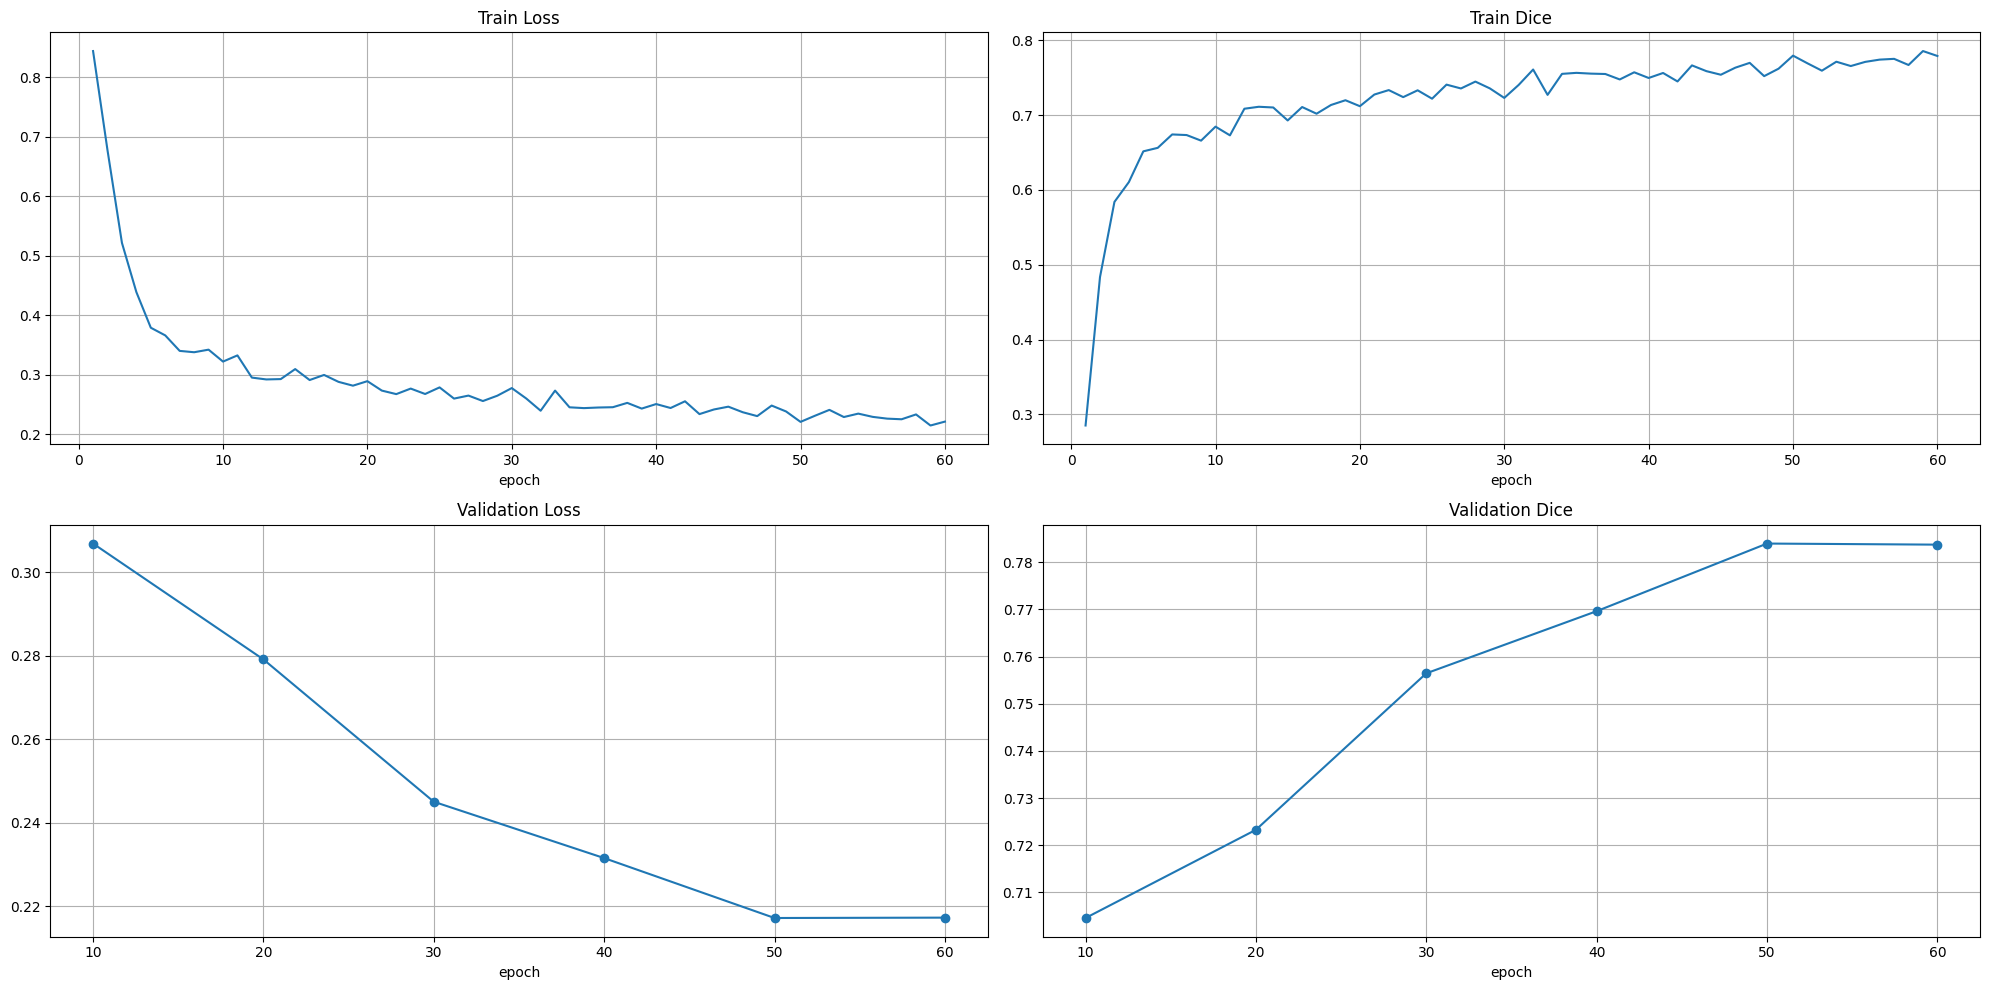

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
df = pd.read_csv('monai/swint1cebinary.csv')

# 2x2 형태의 그래프 생성
plt.figure(figsize=(20, 10))

# Train Loss 그래프
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.title('Train Loss')
plt.xlabel('epoch')
plt.grid(True)

# Train Dice 그래프
plt.subplot(2, 2, 2)
plt.plot(df['epoch'], df['train_dice'], label='Train Dice')
plt.title('Train Dice')
plt.xlabel('epoch')
plt.grid(True)

# Val Loss 그래프
plt.subplot(2, 2, 3)
# 결측치가 아닌 데이터만 필터링
val_data = df[df['val_loss'].notna()]
plt.plot(val_data['epoch'], val_data['val_loss'], 'o-', label='Val Loss')
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.grid(True)

# Val Dice 그래프
plt.subplot(2, 2, 4)
plt.plot(val_data['epoch'], val_data['val_dice'], 'o-', label='Val Dice')
plt.title('Validation Dice')
plt.xlabel('epoch')
plt.grid(True)

# 그래프 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
checkpoint = torch.load('monai/swint1ce.pt')

# 저장된 모든 키 확인
print("저장된 키 목록:", checkpoint.keys())

# 1. 기본 정보
print("\n=== 기본 정보 ===")
print(f"현재 에폭: {checkpoint['epoch']}")
print(f"최고 검증 정확도: {checkpoint['val_acc_max']:.4f}")

# 2. 학습 기록 확인
print("\n=== 학습 기록 ===")
print("Loss 기록:")
print(f"- 전체 기록 수: {len(checkpoint['loss_epochs'])}")
print(f"- 처음 5개: {checkpoint['loss_epochs'][:5]}")
print(f"- 마지막 5개: {checkpoint['loss_epochs'][-5:]}")

print("\nDice Score 기록:")
print(f"- 전체 기록 수: {len(checkpoint['dice_scores'])}")
print(f"- 처음 5개: {checkpoint['dice_scores'][:5]}")
print(f"- 마지막 5개: {checkpoint['dice_scores'][-5:]}")

print("\n학습 Dice 기록:")
print(f"- 전체 기록 수: {len(checkpoint['trains_epoch'])}")
print(f"- 처음 5개: {checkpoint['trains_epoch'][:5]}")
print(f"- 마지막 5개: {checkpoint['trains_epoch'][-5:]}")

# 3. 모델 및 옵티마이저 상태 확인
print("\n=== 상태 저장 확인 ===")
print(f"모델 상태 저장됨: {'model_state_dict' in checkpoint}")
print(f"옵티마이저 상태 저장됨: {'optimizer_state_dict' in checkpoint}")
print(f"스케줄러 상태 저장됨: {'scheduler_state_dict' in checkpoint}")

저장된 키 목록: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'val_acc_max', 'loss_epochs', 'dice_scores', 'trains_epoch'])

=== 기본 정보 ===
현재 에폭: 60
최고 검증 정확도: 0.7840

=== 학습 기록 ===
Loss 기록:
- 전체 기록 수: 60
- 처음 5개: [array(0.84358054), array(0.67711274), array(0.52156072), array(0.43890852), array(0.37911925)]
- 마지막 5개: [array(0.22650797), array(0.22544991), array(0.23356816), array(0.21498913), array(0.22150714)]

Dice Score 기록:
- 전체 기록 수: 6
- 처음 5개: [array(0.70459323), array(0.72329457), array(0.75646109), array(0.76963652), array(0.78396792)]
- 마지막 5개: [array(0.72329457), array(0.75646109), array(0.76963652), array(0.78396792), array(0.7837375)]

학습 Dice 기록:
- 전체 기록 수: 60
- 처음 5개: [array(0.28506461), array(0.48347648), array(0.58399328), array(0.61050546), array(0.65159178)]
- 마지막 5개: [array(0.77421679), array(0.77524507), array(0.76703473), array(0.78566633), array(0.77908102)]

=== 상태 저장 확인 ===
모델 상태 저장됨: True
옵티마이저 상태 저장됨: True
스케줄러 상태 저장됨: True


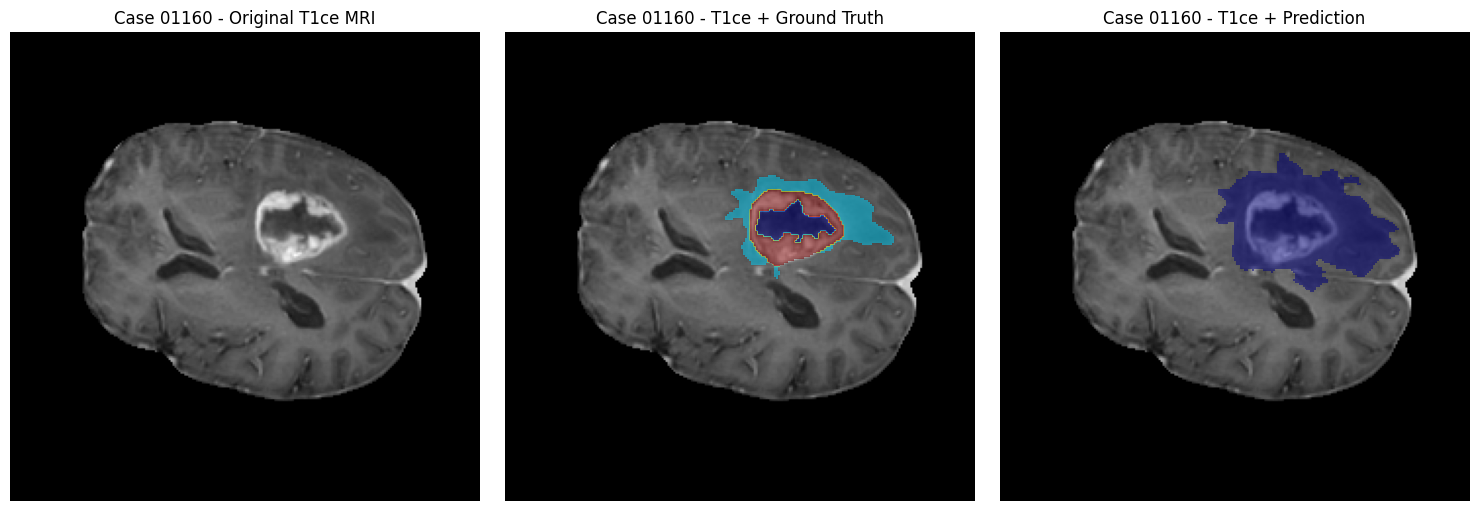

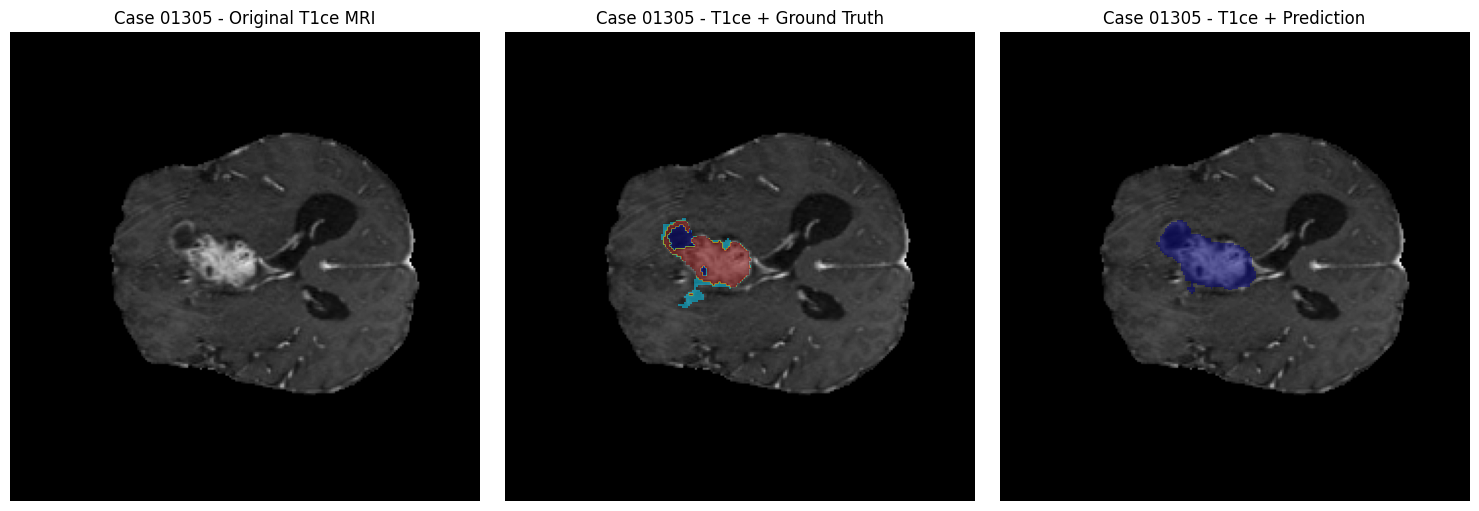

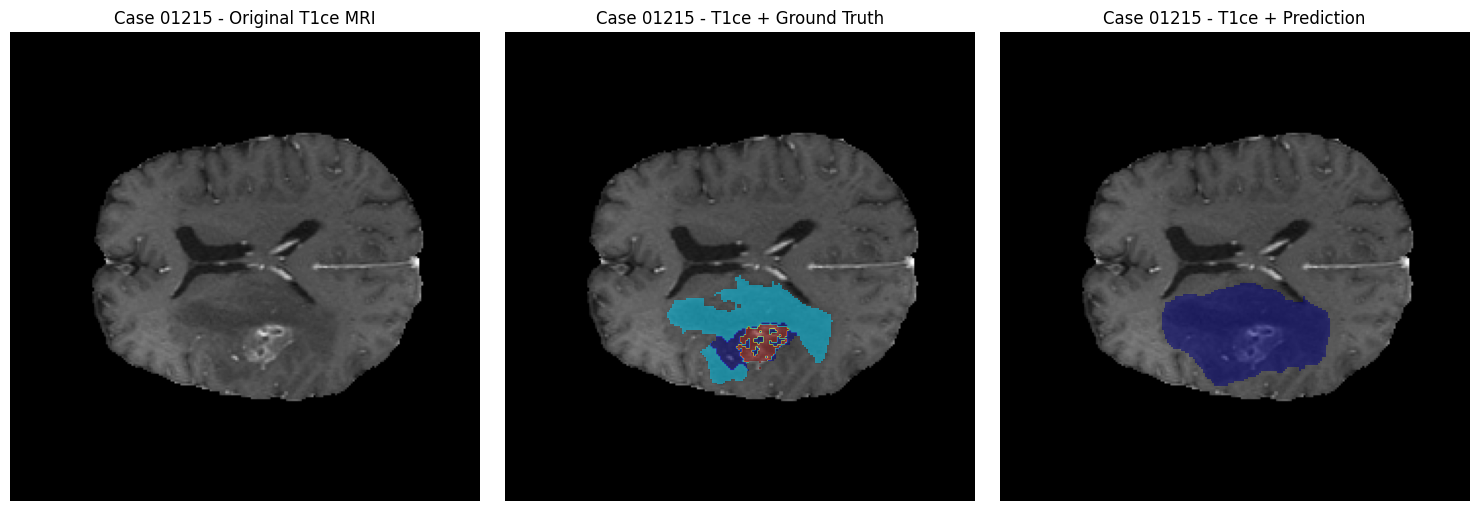

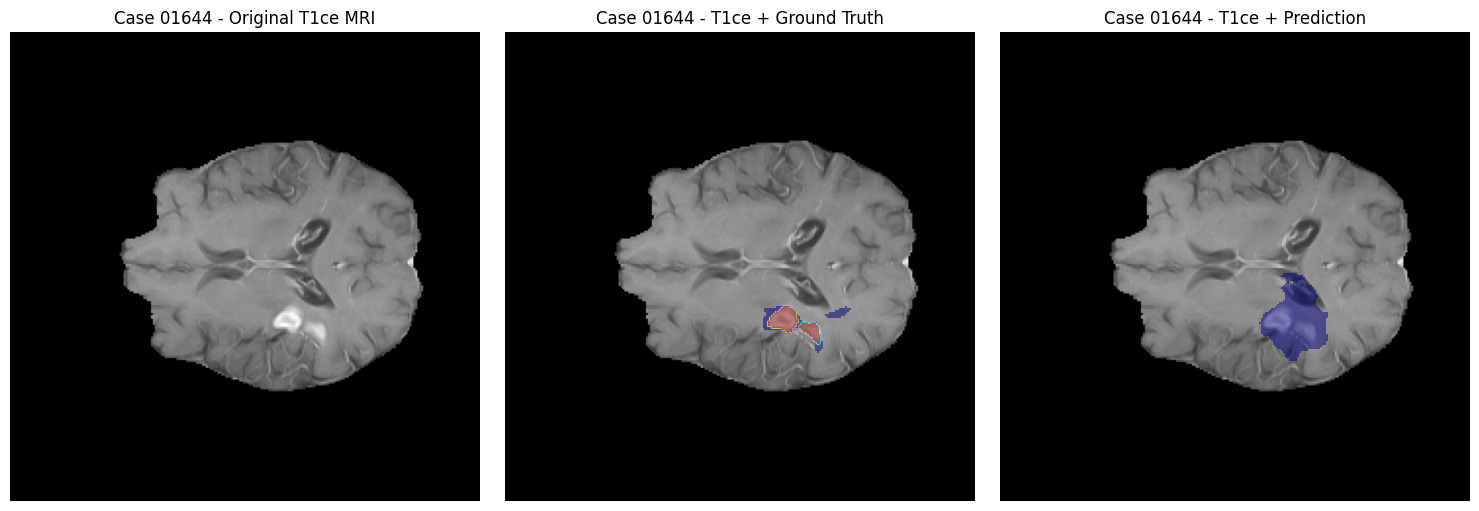

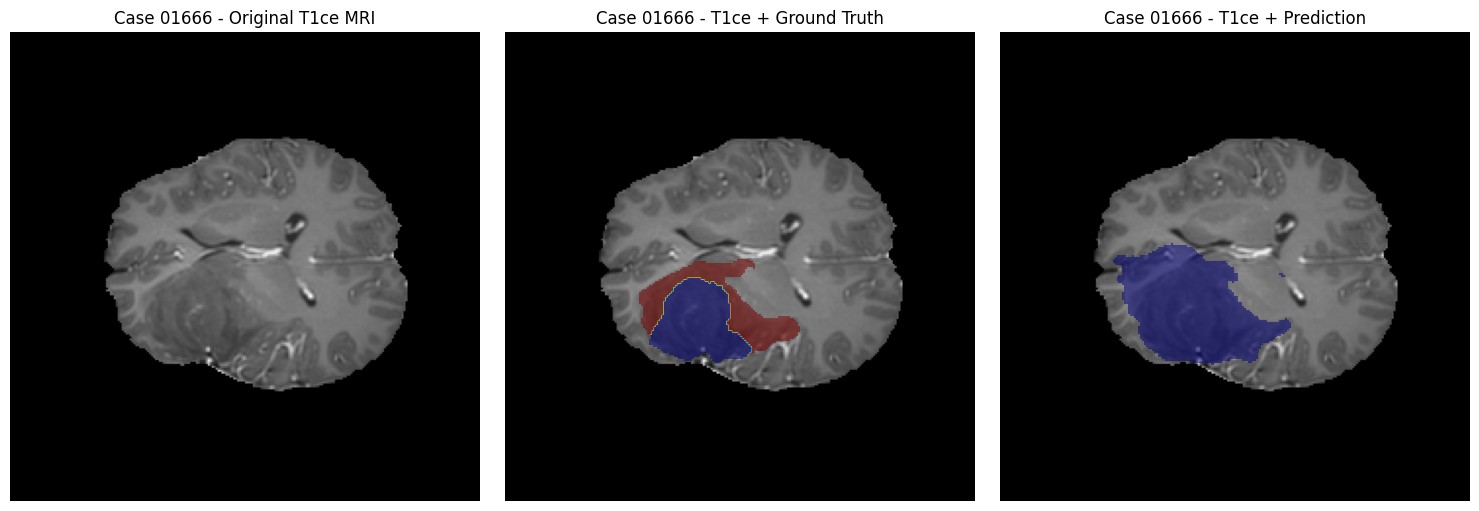

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import numpy as np
from monai import transforms
from monai.networks.nets import SwinUNETR

# 모델 정의
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=(224, 224, 160),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint = torch.load("monai/swint1ce.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Training case IDs
train_cases = ['01160', '01305', '01215', '01644', '01666']

# 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(spatial_size=(224, 224, 160)),
    transforms.NormalizeIntensity(nonzero=True, channel_wise=True)
])

for case_num in train_cases:
    # 이미지 로드
    t1ce_path = f"/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_{case_num}/BraTS2021_{case_num}_t1ce.nii"
    seg_path = f"/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_{case_num}/BraTS2021_{case_num}_seg.nii"
    
    # 이미지 로드 및 전처리
    t1ce_img_orig = nib.load(t1ce_path).get_fdata()
    seg_img = nib.load(seg_path).get_fdata()
    
    # numpy array에 채널 차원 추가 및 전처리
    t1ce_img_orig = np.expand_dims(t1ce_img_orig, axis=0)
    t1ce_img = transform(t1ce_img_orig)
    t1ce_img = t1ce_img.array
    t1ce_img = np.expand_dims(t1ce_img, axis=0)

    # 예측
    with torch.no_grad():
        input_tensor = torch.from_numpy(t1ce_img).float().to(device)
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        pred = pred.cpu().numpy().squeeze()

    # 예측 결과를 원본 크기로 리사이즈
    pred = torch.from_numpy(pred).unsqueeze(0)
    resize_back = transforms.Resize(spatial_size=(240, 240, 155), mode="nearest")
    pred = resize_back(pred)[0].numpy()

    # 시각화
    slice_num = t1ce_img_orig.shape[-1] // 2

    plt.figure(figsize=(15, 5))

    # Original T1
    plt.subplot(1, 3, 1)
    plt.title(f'Case {case_num} - Original T1ce MRI')
    plt.imshow(t1ce_img_orig[0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    # T1 + Ground Truth Overlay
    plt.subplot(1, 3, 2)
    plt.title(f'Case {case_num} - T1ce + Ground Truth')
    plt.imshow(t1ce_img_orig[0, :, :, slice_num], cmap='gray')
    mask = np.ma.masked_where(seg_img[:, :, slice_num] == 0, seg_img[:, :, slice_num])
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    # T1 + Prediction Overlay
    plt.subplot(1, 3, 3)
    plt.title(f'Case {case_num} - T1ce + Prediction')
    plt.imshow(t1ce_img_orig[0, :, :, slice_num], cmap='gray')
    pred_mask = np.ma.masked_where(pred[:, :, slice_num] == 0, pred[:, :, slice_num])
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

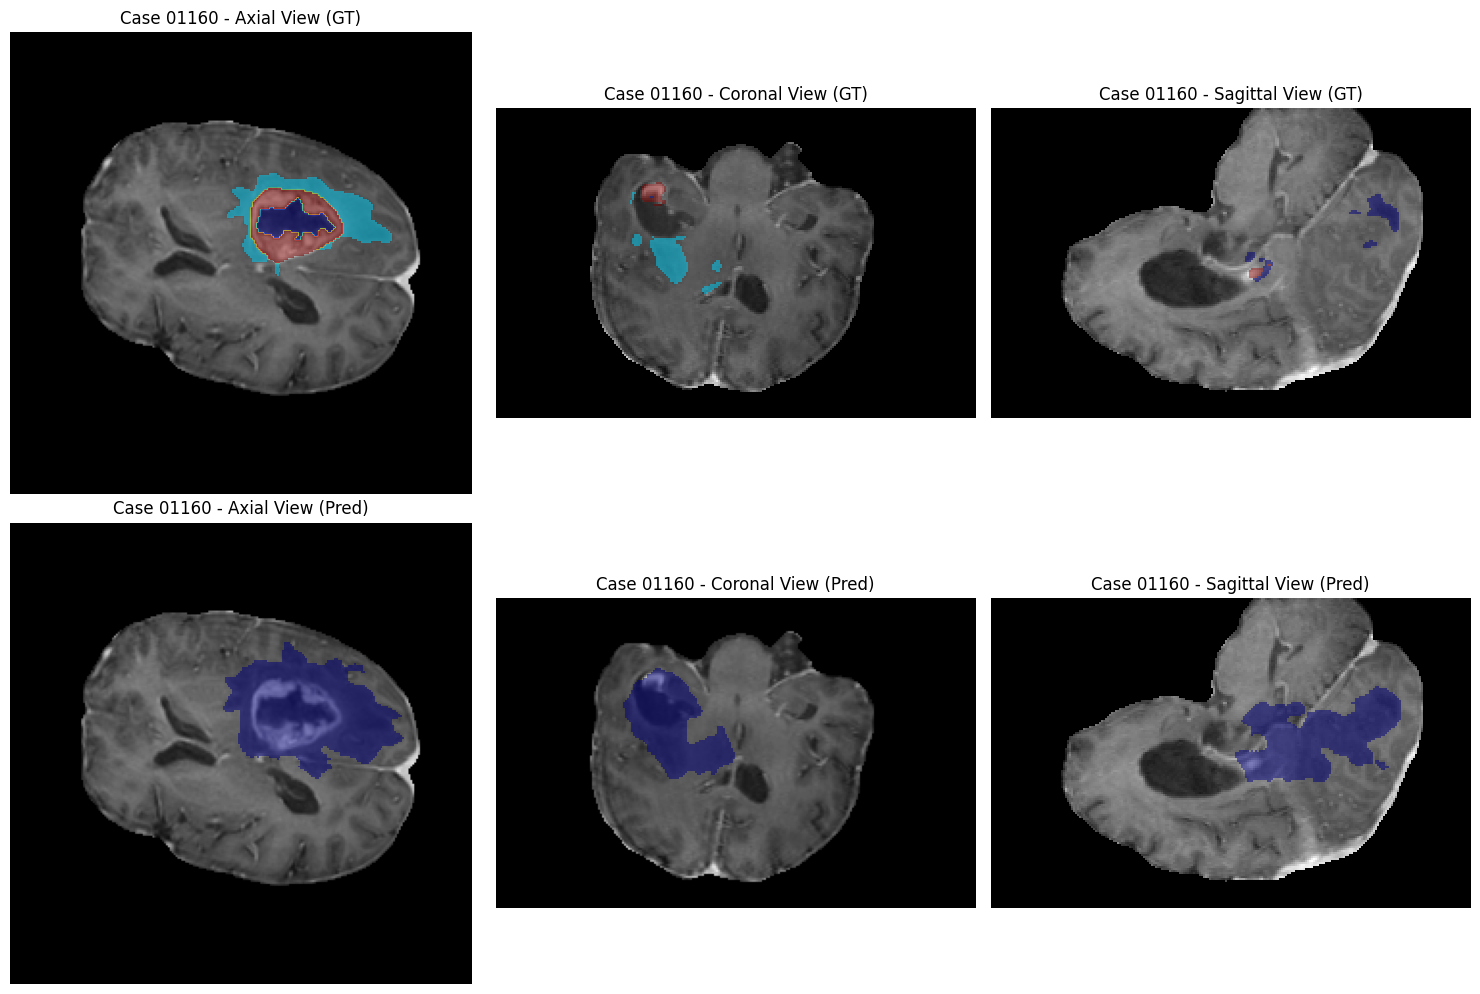

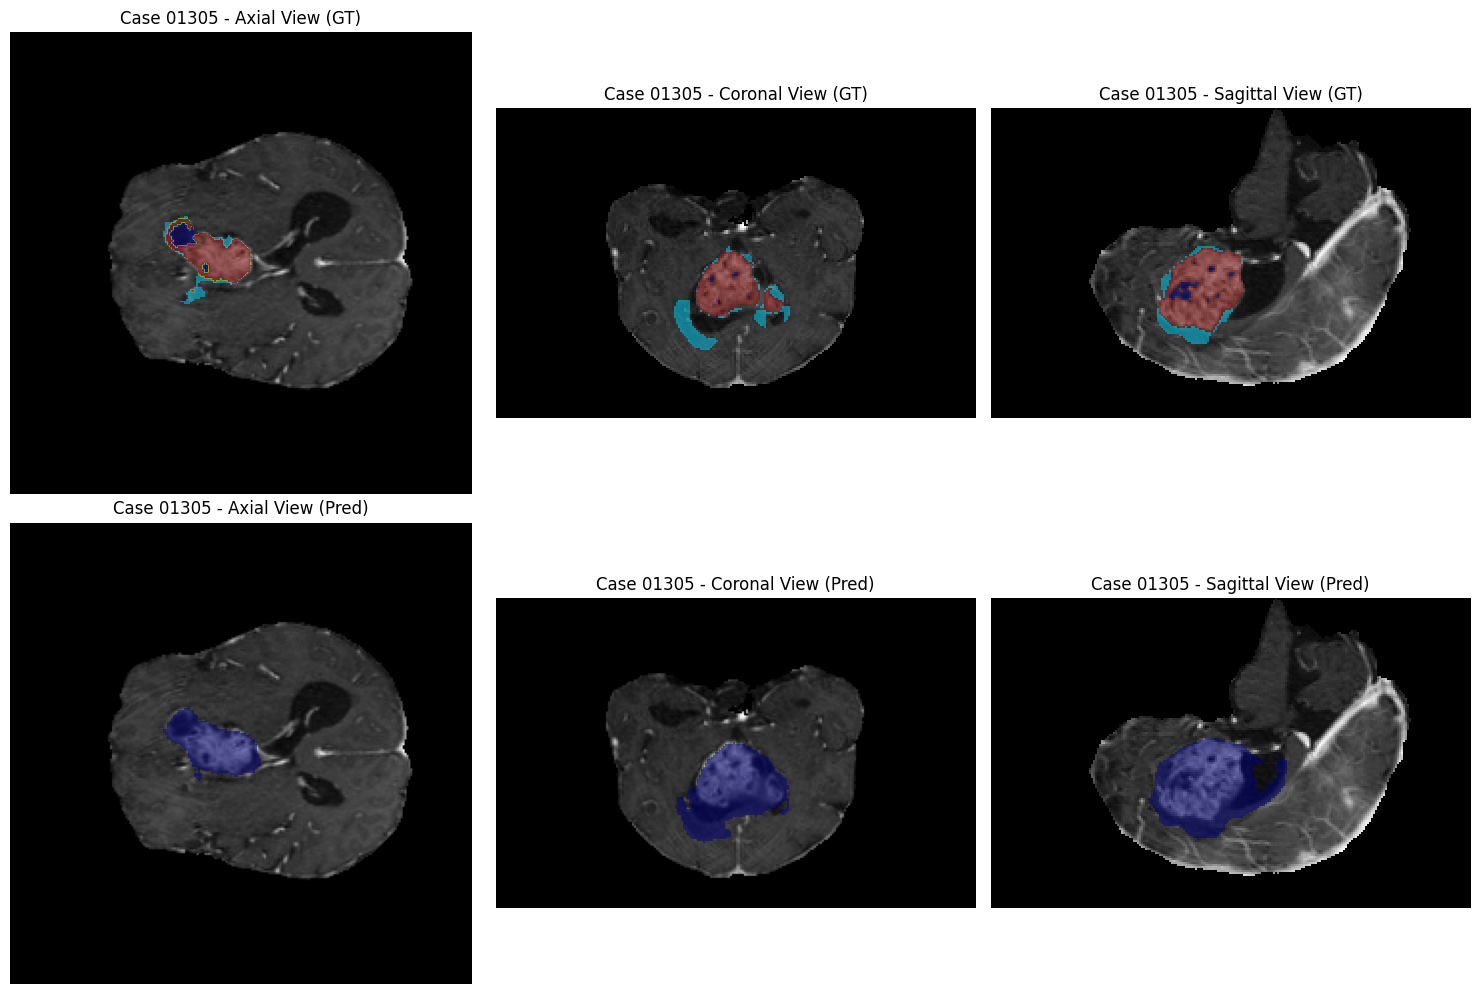

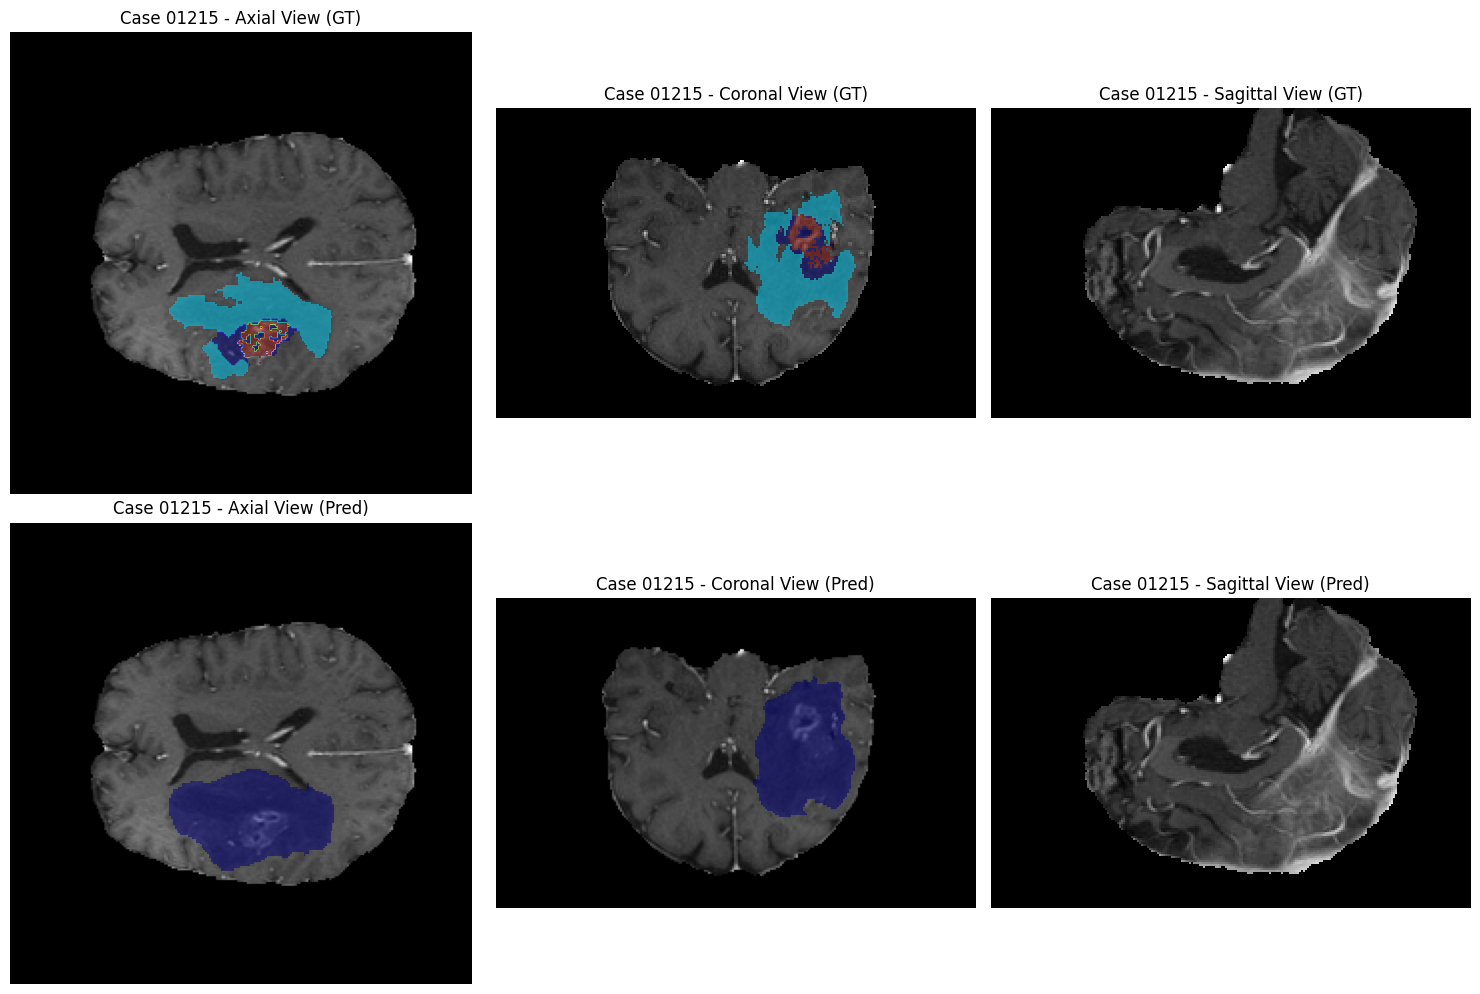

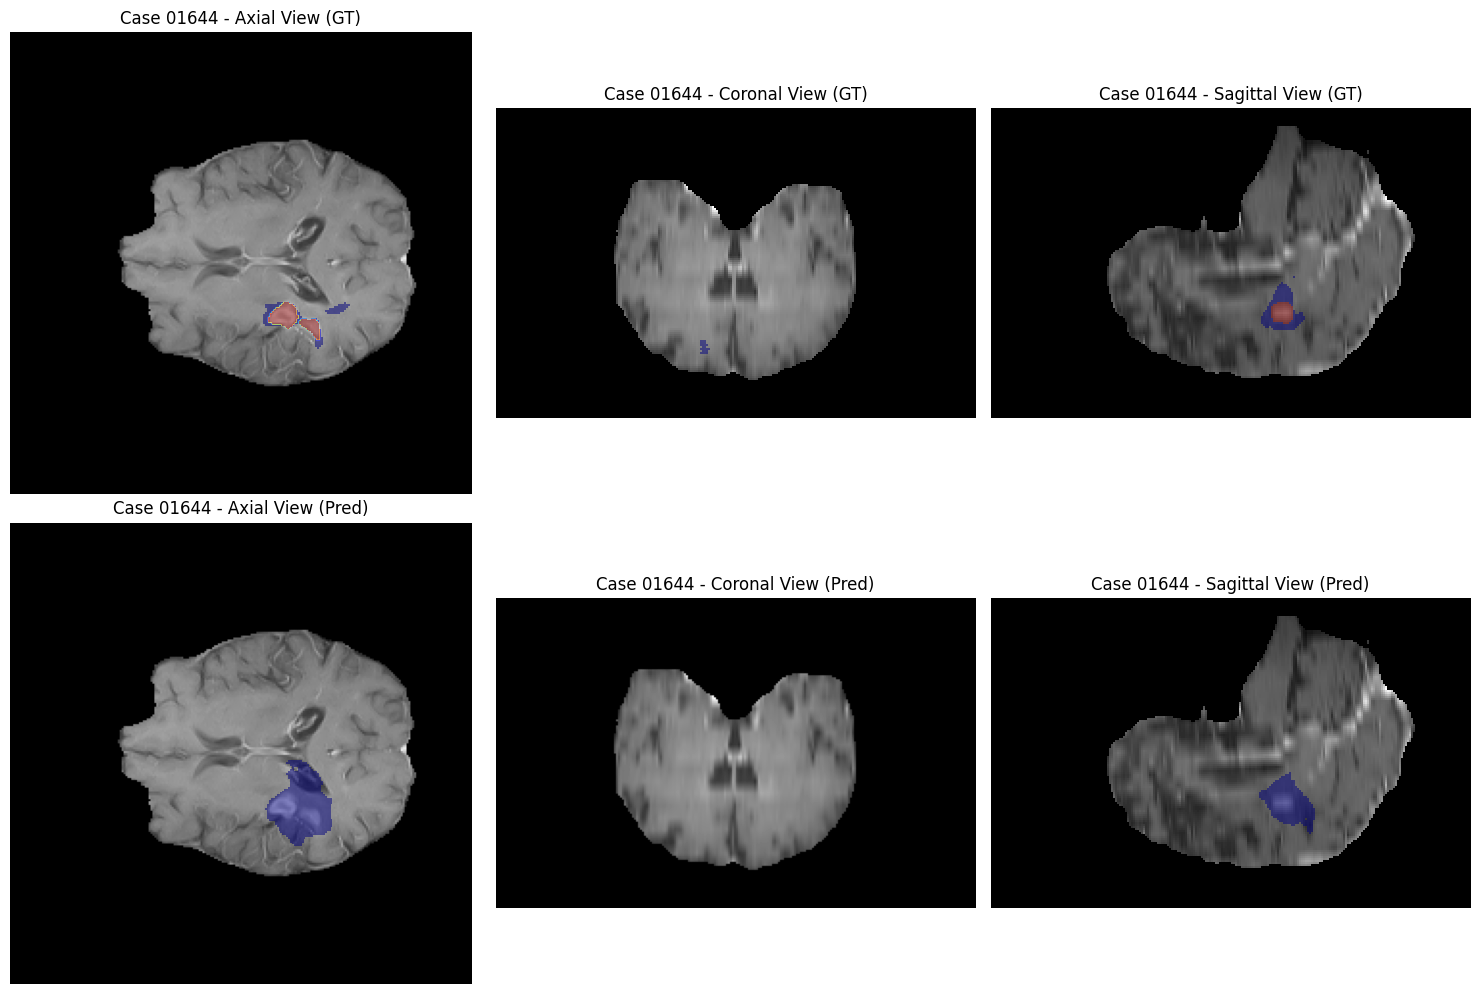

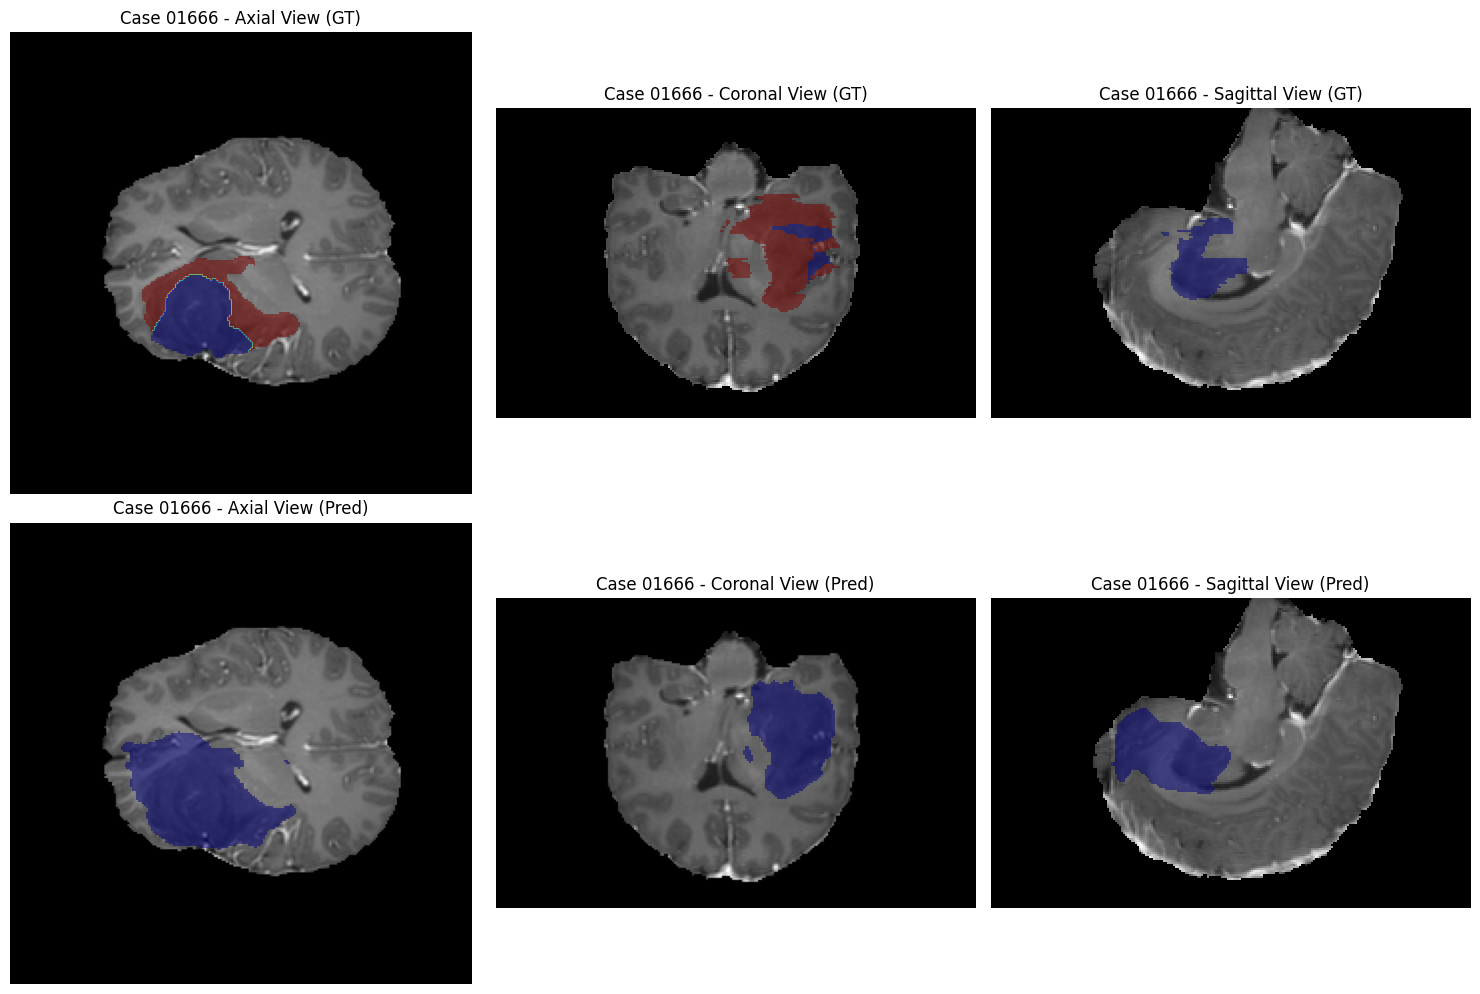

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import numpy as np
from monai import transforms
from monai.networks.nets import SwinUNETR

# 모델 정의
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=(224, 224, 160),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint = torch.load("monai/swint1ce.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Training case IDs
train_cases = ['01160', '01305', '01215', '01644', '01666']

# 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(spatial_size=(224, 224, 160)),
    transforms.NormalizeIntensity(nonzero=True, channel_wise=True)
])

for case_num in train_cases:
    # 이미지 로드
    t1ce_path = f"/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_{case_num}/BraTS2021_{case_num}_t1ce.nii"
    seg_path = f"/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_{case_num}/BraTS2021_{case_num}_seg.nii"
    
    # 이미지 로드 및 전처리
    t1ce_img_orig = nib.load(t1ce_path).get_fdata()
    seg_img = nib.load(seg_path).get_fdata()
    
    # numpy array에 채널 차원 추가 및 전처리
    t1ce_img_orig = np.expand_dims(t1ce_img_orig, axis=0)
    t1ce_img = transform(t1ce_img_orig)
    t1ce_img = t1ce_img.array
    t1ce_img = np.expand_dims(t1ce_img, axis=0)

    # 예측
    with torch.no_grad():
        input_tensor = torch.from_numpy(t1ce_img).float().to(device)
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        pred = pred.cpu().numpy().squeeze()

    # 예측 결과를 원본 크기로 리사이즈
    pred = torch.from_numpy(pred).unsqueeze(0)
    resize_back = transforms.Resize(spatial_size=(240, 240, 155), mode="nearest")
    pred = resize_back(pred)[0].numpy()

    # 중간 슬라이스 계산
    axial_slice = t1ce_img_orig.shape[-1] // 2
    coronal_slice = t1ce_img_orig.shape[-2] // 2
    sagittal_slice = t1ce_img_orig.shape[-3] // 2

    plt.figure(figsize=(15, 10))

    # Ground Truth - Axial view
    plt.subplot(2, 3, 1)
    plt.title(f'Case {case_num} - Axial View (GT)')
    plt.imshow(t1ce_img_orig[0, :, :, axial_slice], cmap='gray')
    mask = np.ma.masked_where(seg_img[:, :, axial_slice] == 0, seg_img[:, :, axial_slice])
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    # Ground Truth - Coronal view
    plt.subplot(2, 3, 2)
    plt.title(f'Case {case_num} - Coronal View (GT)')
    plt.imshow(t1ce_img_orig[0, :, coronal_slice, :].T, cmap='gray')
    mask = np.ma.masked_where(seg_img[:, coronal_slice, :].T == 0, seg_img[:, coronal_slice, :].T)
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    # Ground Truth - Sagittal view
    plt.subplot(2, 3, 3)
    plt.title(f'Case {case_num} - Sagittal View (GT)')
    plt.imshow(t1ce_img_orig[0, sagittal_slice, :, :].T, cmap='gray')
    mask = np.ma.masked_where(seg_img[sagittal_slice, :, :].T == 0, seg_img[sagittal_slice, :, :].T)
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    # Prediction - Axial view
    plt.subplot(2, 3, 4)
    plt.title(f'Case {case_num} - Axial View (Pred)')
    plt.imshow(t1ce_img_orig[0, :, :, axial_slice], cmap='gray')
    pred_mask = np.ma.masked_where(pred[:, :, axial_slice] == 0, pred[:, :, axial_slice])
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    # Prediction - Coronal view
    plt.subplot(2, 3, 5)
    plt.title(f'Case {case_num} - Coronal View (Pred)')
    plt.imshow(t1ce_img_orig[0, :, coronal_slice, :].T, cmap='gray')
    pred_mask = np.ma.masked_where(pred[:, coronal_slice, :].T == 0, pred[:, coronal_slice, :].T)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    # Prediction - Sagittal view
    plt.subplot(2, 3, 6)
    plt.title(f'Case {case_num} - Sagittal View (Pred)')
    plt.imshow(t1ce_img_orig[0, sagittal_slice, :, :].T, cmap='gray')
    pred_mask = np.ma.masked_where(pred[sagittal_slice, :, :].T == 0, pred[sagittal_slice, :, :].T)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

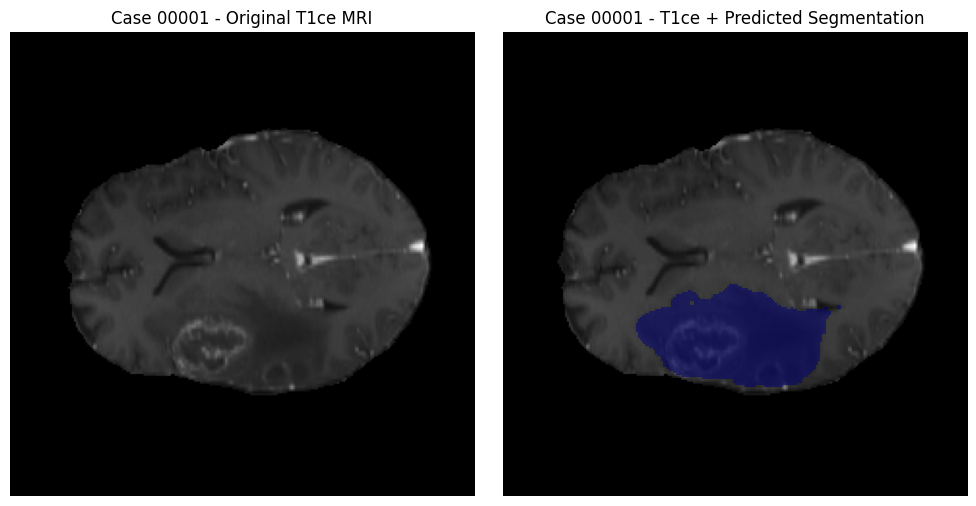

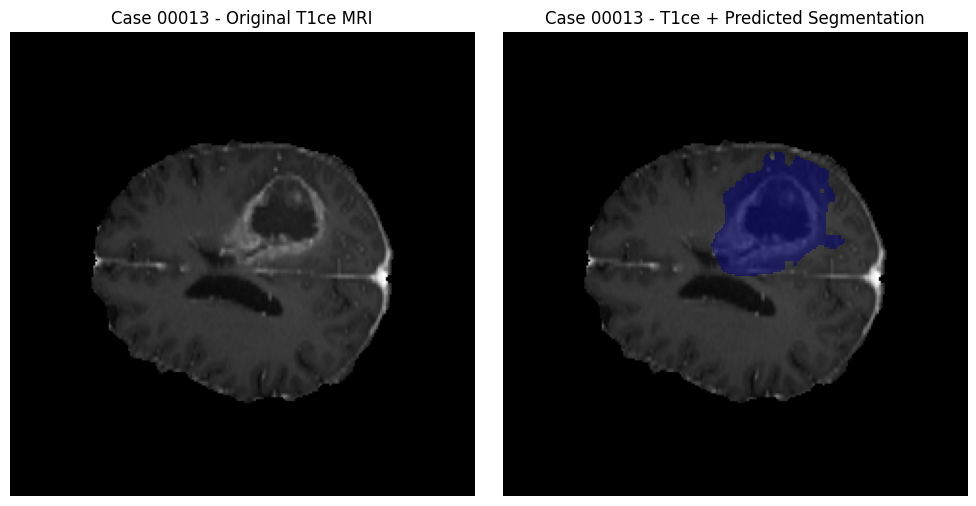

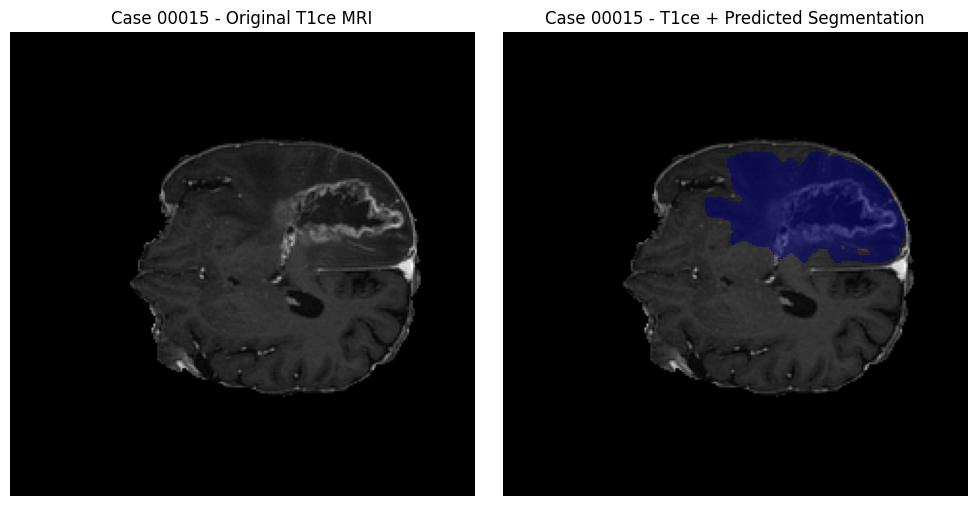

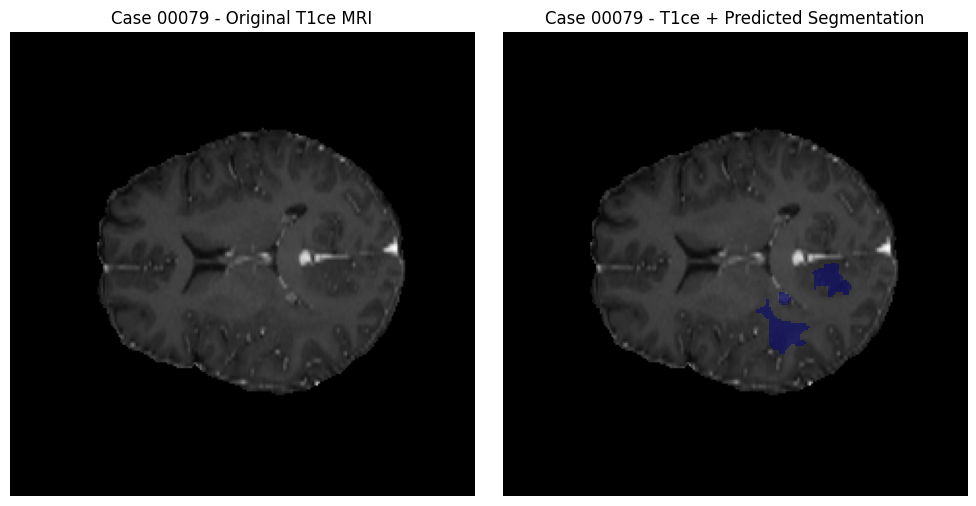

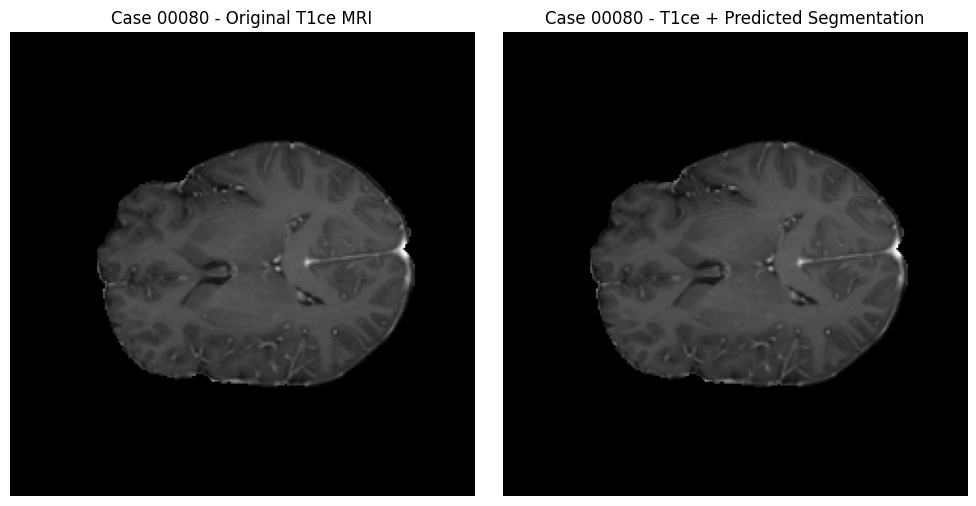

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import numpy as np
from monai import transforms
from monai.networks.nets import SwinUNETR

# 모델 정의
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=(224, 224, 160),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint = torch.load("monai/swint1ce.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Validation case IDs
val_cases = ['00001', '00013', '00015', '00079', '00080']

# 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(spatial_size=(224, 224, 160)),
    transforms.NormalizeIntensity(nonzero=True, channel_wise=True)
])

for case_num in val_cases:
    # 이미지 로드
    t1ce_path = f"/home/alpaco/msk/BraTS2021_Validation_Data/BraTS2021_{case_num}/BraTS2021_{case_num}_t1ce.nii"
    
    # 이미지 로드 및 전처리
    t1ce_img_orig = nib.load(t1ce_path).get_fdata()
    t1ce_img_orig = np.expand_dims(t1ce_img_orig, axis=0)  # Add channel dimension
    t1ce_img = transform(t1ce_img_orig)  
    t1ce_img = t1ce_img.array  # MetaTensor를 numpy array로 변환
    t1ce_img = np.expand_dims(t1ce_img, axis=0)  # [B, C, H, W, D]

    # 예측
    with torch.no_grad():
        input_tensor = torch.from_numpy(t1ce_img).float().to(device)
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        pred = pred.cpu().numpy().squeeze()

    # 예측 결과를 원본 크기로 다시 리사이즈
    pred = torch.from_numpy(pred).unsqueeze(0)
    resize_back = transforms.Resize(spatial_size=(240, 240, 155), mode="nearest")
    pred = resize_back(pred)[0].numpy()

    # 시각화
    slice_num = t1ce_img_orig.shape[-1] // 2

    plt.figure(figsize=(10, 5))

    # Original T1
    plt.subplot(1, 2, 1)
    plt.title(f'Case {case_num} - Original T1ce MRI')
    plt.imshow(t1ce_img_orig[0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    # T1 + Prediction Overlay
    plt.subplot(1, 2, 2)
    plt.title(f'Case {case_num} - T1ce + Predicted Segmentation')
    plt.imshow(t1ce_img_orig[0, :, :, slice_num], cmap='gray')
    pred_mask = np.ma.masked_where(pred[:, :, slice_num] == 0, pred[:, :, slice_num])
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

/home/alpaco/anaconda3/envs/msk/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


체크포인트 로드 완료

처리 중: 환자 0


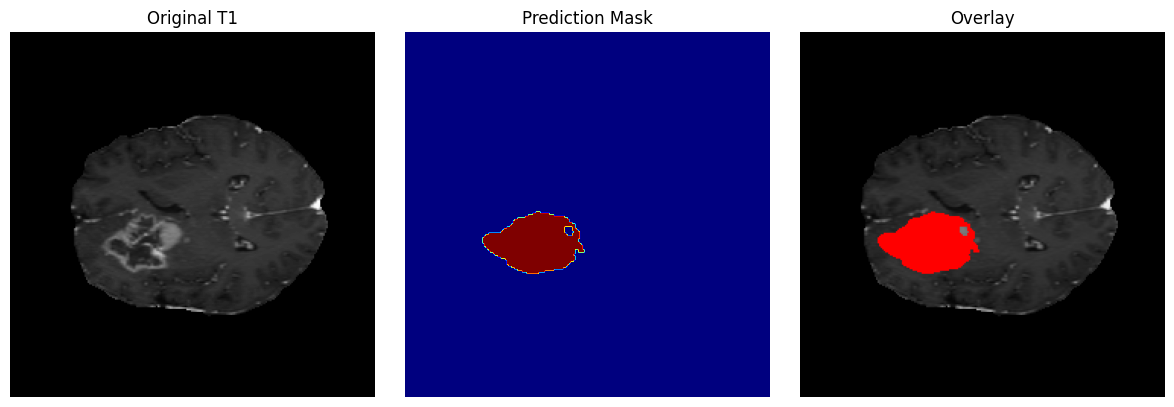

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00000.nii.gz에 저장되었습니다.
환자 00000 처리 완료

처리 중: 환자 1


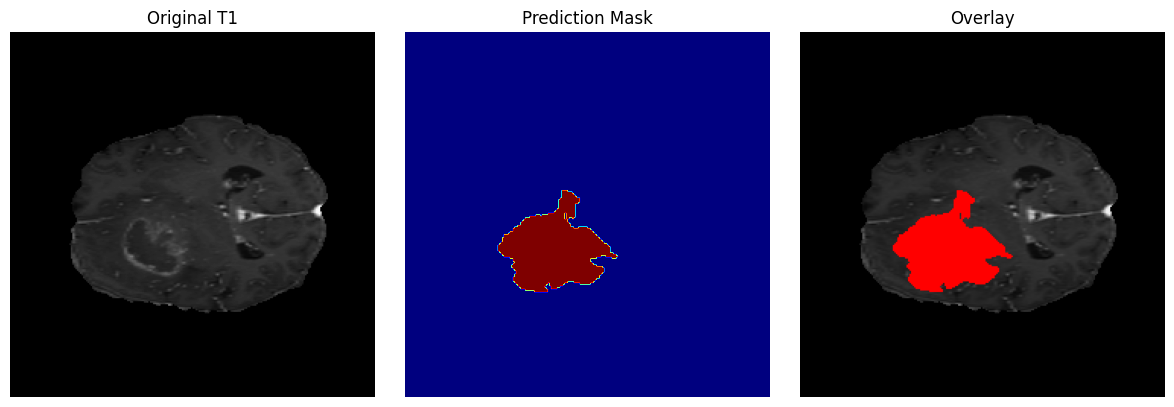

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00002.nii.gz에 저장되었습니다.
환자 00002 처리 완료

처리 중: 환자 2


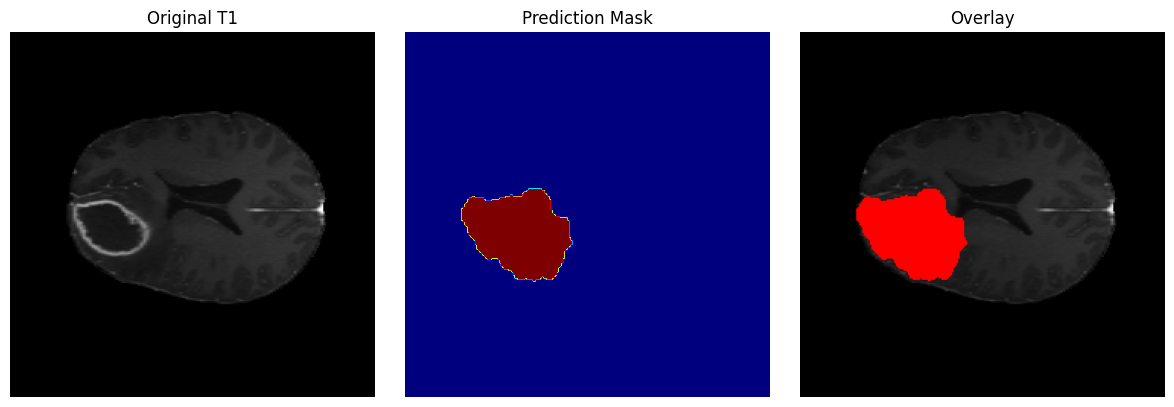

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00006.nii.gz에 저장되었습니다.
환자 00006 처리 완료

처리 중: 환자 3


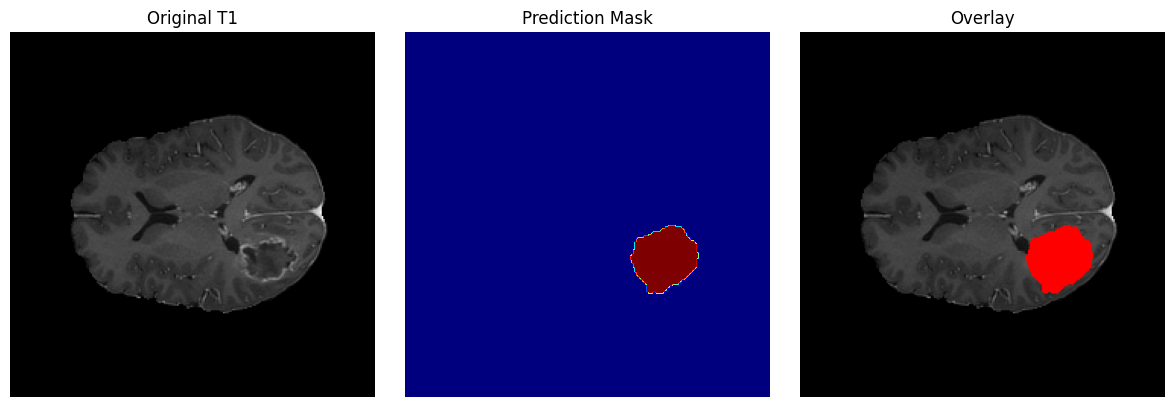

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00016.nii.gz에 저장되었습니다.
환자 00016 처리 완료

처리 중: 환자 4


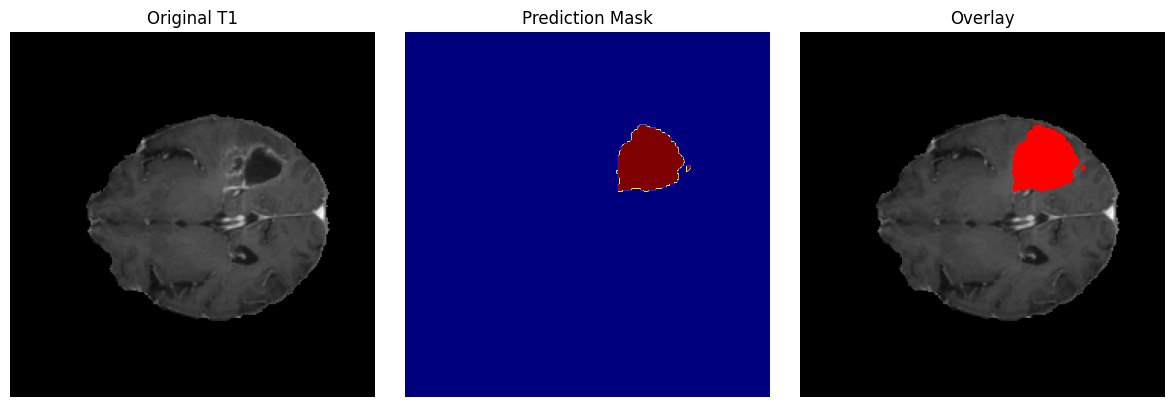

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00022.nii.gz에 저장되었습니다.
환자 00022 처리 완료

처리 중: 환자 5


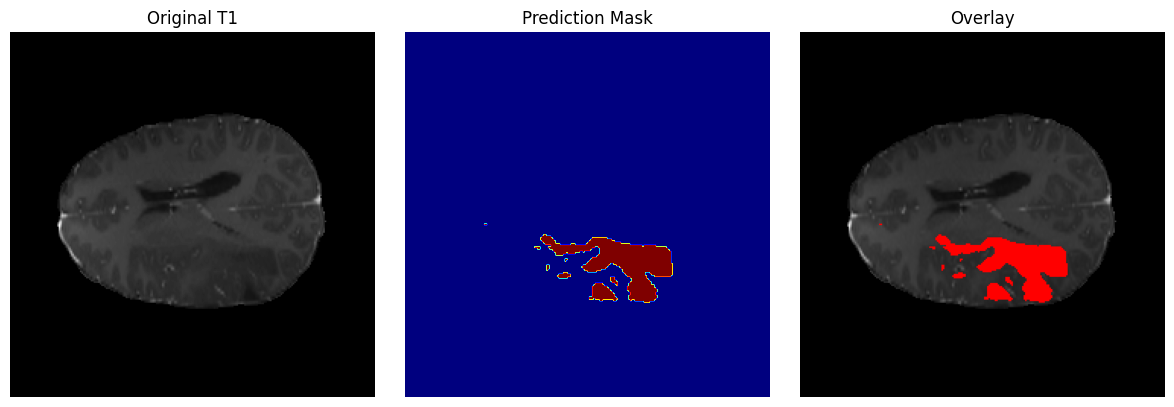

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00033.nii.gz에 저장되었습니다.
환자 00033 처리 완료

처리 중: 환자 6


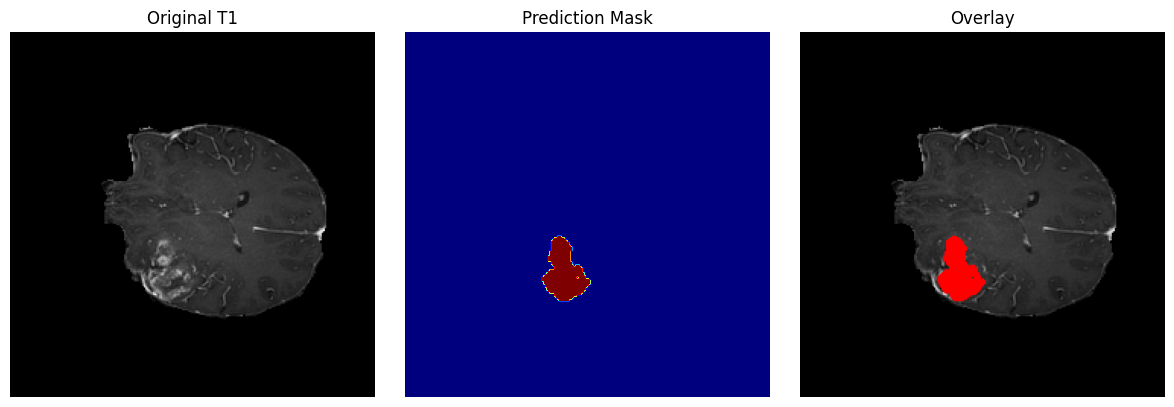

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00054.nii.gz에 저장되었습니다.
환자 00054 처리 완료

처리 중: 환자 7


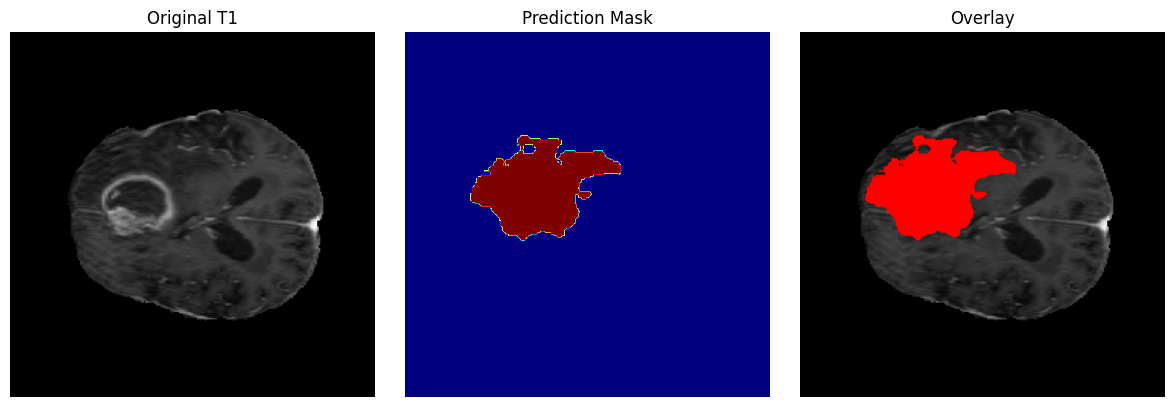

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00077.nii.gz에 저장되었습니다.
환자 00077 처리 완료

처리 중: 환자 8


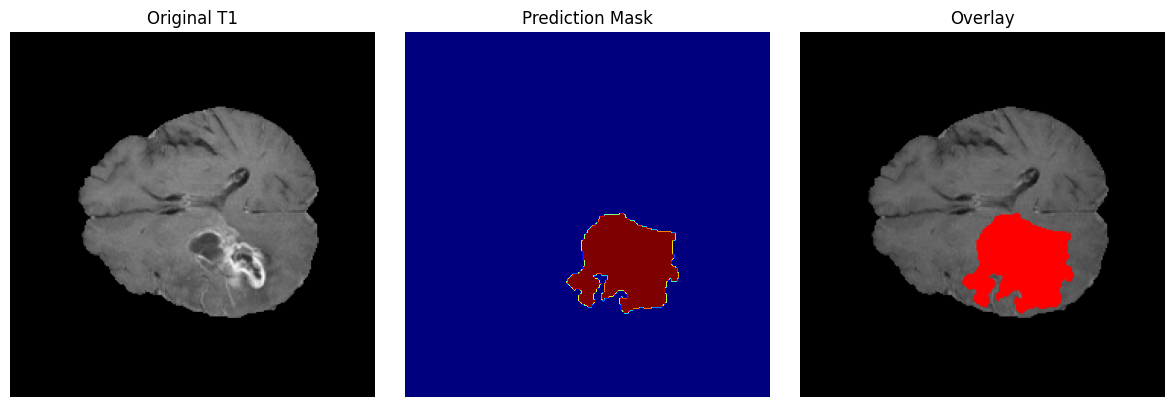

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00105.nii.gz에 저장되었습니다.
환자 00105 처리 완료

처리 중: 환자 9


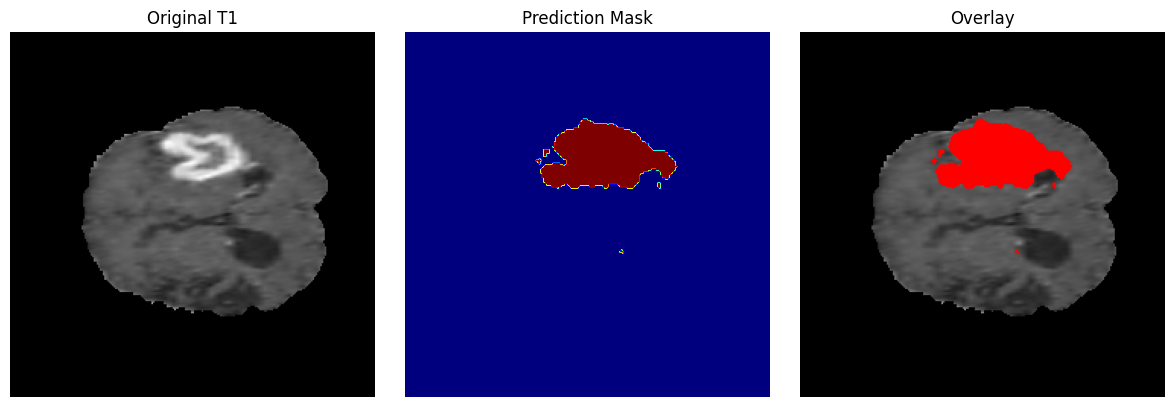

오버레이 이미지가 /home/alpaco/msk/monai/predictions/t1ce/prediction_t1ce_overlay_00143.nii.gz에 저장되었습니다.
환자 00143 처리 완료

모든 예측 및 시각화가 완료되었습니다.

생성된 파일 목록:
- prediction_t1ce_overlay_00000.nii.gz
- prediction_t1ce_overlay_00002.nii.gz
- prediction_t1ce_overlay_00006.nii.gz
- prediction_t1ce_overlay_00016.nii.gz
- prediction_t1ce_overlay_00022.nii.gz
- prediction_t1ce_overlay_00033.nii.gz
- prediction_t1ce_overlay_00054.nii.gz
- prediction_t1ce_overlay_00077.nii.gz
- prediction_t1ce_overlay_00105.nii.gz
- prediction_t1ce_overlay_00143.nii.gz


In [ ]:
from functools import partial 
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms, data
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
)

# 디바이스 설정
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# 모델 설정
roi = (128, 128, 128)
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint_path = "monai/swint1ce.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("체크포인트 로드 완료")
else:
    print("체크포인트 파일을 찾을 수 없습니다!")

# 후처리 함수 설정
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# sliding window inference 설정
sw_batch_size = 4
infer_overlap = 0.5

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

def save_prediction_overlay(t1ce_path, prediction_array, output_path, slice_idx=None):

    # 원본 T1ce 이미지 로드
    t1ce_img = nib.load(t1ce_path)
    t1ce_data = t1ce_img.get_fdata()
    
    # 차원 확인 및 조정
    if prediction_array.shape != t1ce_data.shape:
        raise ValueError(f"예측 마스크 shape {prediction_array.shape}가 T1ce 이미지 shape {t1_data.shape}와 일치하지 않습니다.")
    
    # 시각화를 위해 T1ce 이미지 정규화 (0-1 범위로)
    t1ce_norm = (t1ce_data - t1ce_data.min()) / (t1ce_data.max() - t1ce_data.min())
    
    # RGB 이미지 생성 (4D: x, y, z, RGB)
    overlay = np.zeros((*t1ce_data.shape, 4))  # RGBA
    
    # T1 이미지를 회색조로 설정
    overlay[..., 0] = t1ce_norm  # R
    overlay[..., 1] = t1ce_norm  # G
    overlay[..., 2] = t1ce_norm  # B
    overlay[..., 3] = 1.0      # A (완전 불투명)
    
    # 예측된 부분을 빨간색으로 오버레이
    mask = prediction_array > 0.5  # 이진 마스크로 변환
    overlay[mask, 0] = 1.0  # R (빨간색)
    overlay[mask, 1] = 0.0  # G
    overlay[mask, 2] = 0.0  # B
    overlay[mask, 3] = 1.0  # A
    
    # 특정 슬라이스 시각화 (디버깅용)
    if slice_idx is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(t1ce_norm[:, :, slice_idx], cmap='gray')
        plt.title('Original T1')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask[:, :, slice_idx], cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(overlay[:, :, slice_idx, :3])  # RGB만 표시
        plt.title('Overlay')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # nii 파일로 저장
    overlay_img = nib.Nifti1Image(overlay, t1ce_img.affine, t1ce_img.header)
    nib.save(overlay_img, output_path)
    print(f"오버레이 이미지가 {output_path}에 저장되었습니다.")

# 테스트할 환자 데이터 직접 지정
test_data = [
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00002/BraTS2021_00002_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00006/BraTS2021_00006_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00016/BraTS2021_00016_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00022/BraTS2021_00022_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00033/BraTS2021_00033_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00054/BraTS2021_00054_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00077/BraTS2021_00077_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00105/BraTS2021_00105_t1ce.nii"]
    },
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00143/BraTS2021_00143_t1ce.nii"]
    },
]

# 테스트용 transform 설정
test_transform = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# 테스트 데이터셋과 로더 생성
test_ds = data.Dataset(data=test_data, transform=test_transform)
test_loader = data.DataLoader(test_ds, batch_size=1)

# 결과 저장 디렉토리 생성
output_dir = "/home/alpaco/msk/monai/predictions/t1ce"
os.makedirs(output_dir, exist_ok=True)

# 모델을 평가 모드로 설정
model.eval()

# 각 환자별로 예측 수행
with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        print(f"\n처리 중: 환자 {idx}")
        
        # 예측 수행
        data = batch_data["image"].to(device)
        pred = model_inferer(data)
        pred = post_sigmoid(pred)
        pred = post_pred(pred)
        pred_np = pred.cpu().numpy()
        
        # 원본 파일 경로와 출력 파일 경로
        t1ce_path = test_data[idx]["image"][0]
        patient_id = os.path.basename(t1ce_path).split('_')[1]  # BraTS2021_00000에서 00000 추출
        output_path = os.path.join(output_dir, f"prediction_t1ce_overlay_{patient_id}.nii.gz")
        
        # 중간 슬라이스 계산 (시각화용)
        middle_slice = pred_np.shape[-1] // 2
        
        # 예측 결과 저장 및 시각화
        save_prediction_overlay(t1ce_path, pred_np[0, 0], output_path, slice_idx=middle_slice)
        
        print(f"환자 {patient_id} 처리 완료")

print("\n모든 예측 및 시각화가 완료되었습니다.")

# 처리된 파일 목록 출력
print("\n생성된 파일 목록:")
for file in sorted(os.listdir(output_dir)):
    if file.startswith("prediction_t1ce_overlay_"):
        print(f"- {file}")